Importing all the packages

In [5]:
import torch, os
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn # Needed for modifying layers
import matplotlib.pyplot as plt
import numpy as np

Importing datasets

Downloading/Loading MNIST dataset...
Dataset loaded.
Number of training images: 60000
Number of test images: 10000
Created DataLoaders with batch size 1200.

Displaying the first 5 training images (after denormalization)...


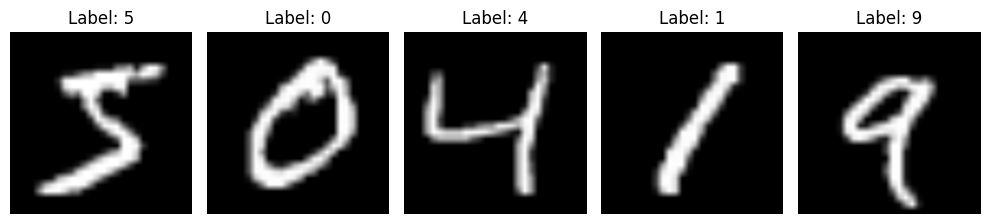


Iterating through one batch from train_loader:
Batch of images shape: torch.Size([1200, 1, 224, 224])
Batch of labels shape: torch.Size([1200])


In [7]:
# 1. Define Transformations for the Dataset
#    - ToTensor(): Converts images to PyTorch tensors (C x H x W) in range [0.0, 1.0]
#    - Normalize((0.5,), (0.5,)): Normalizes tensor image with mean 0.5 and std 0.5.
#      This shifts the range from [0.0, 1.0] to [-1.0, 1.0]
transform = transforms.Compose([
    transforms.ToTensor(),
    Resize((224, 224)), # Resize to 224x224 for compatibility with models like ResNet
    transforms.Normalize((0.5,), (0.5,)) # Mean and std for the single grayscale channel
])

# 2. Load the MNIST Dataset
print("Downloading/Loading MNIST dataset...")
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print("Dataset loaded.")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

# 3. Create DataLoaders for Batching
#    - DataLoader provides an iterator over the dataset in batches.
#    - shuffle=True is important for training to ensure batches are different each epoch.
batch_size = 1200 # You can change this
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle test data
print(f"Created DataLoaders with batch size {batch_size}.")

# 4. Function to View Images (Denormalizing)
def imshow_denormalize(img_tensor, title):
    # Reverse the normalization: image = normalized_image * std + mean
    img = img_tensor * 0.5 + 0.5
    # Clamp values to [0, 1] just in case of potential floating point inaccuracies
    img = torch.clamp(img, 0, 1)
    # Remove channel dimension and convert to numpy for plotting
    npimg = img.squeeze().numpy()
    plt.imshow(npimg, cmap='gray')
    plt.title(title)
    plt.axis('off')

# Display the first 5 images from the training dataset
num_images_to_show = 5
print(f"\nDisplaying the first {num_images_to_show} training images (after denormalization)...")
plt.figure(figsize=(10, 3))

for i in range(num_images_to_show):
    # Get image and label directly from the dataset (before batching)
    image, label = train_dataset[i]
    plt.subplot(1, num_images_to_show, i + 1)
    imshow_denormalize(image, f'Label: {label}')

plt.tight_layout()
plt.show()


# 5. Example: Iterate through one batch of the training data via DataLoader
print("\nIterating through one batch from train_loader:")
# Get one batch
try:
    images, labels = next(iter(train_loader))
    # Print the shapes of the batch
    print(f"Batch of images shape: {images.shape}") # e.g., [64, 1, 28, 28] (Batch Size, Channels, Height, Width)
    print(f"Batch of labels shape: {labels.shape}")   # e.g., [64]
except StopIteration:
    print("Could not get a batch from train_loader (maybe dataset is empty?)")


========== Processing Dataset: MNIST ==========
PyTorch Version: 2.6.0+cu124
Torchvision Version: 0.21.0+cu124
Data will be stored in: ./data/mnist_mnist
Downloading/Loading MNIST dataset...
MNIST dataset loaded.
Number of training images: 60000
Number of test images: 10000
Created MNIST DataLoaders with batch size 1024.

Displaying the first 5 MNIST training images...


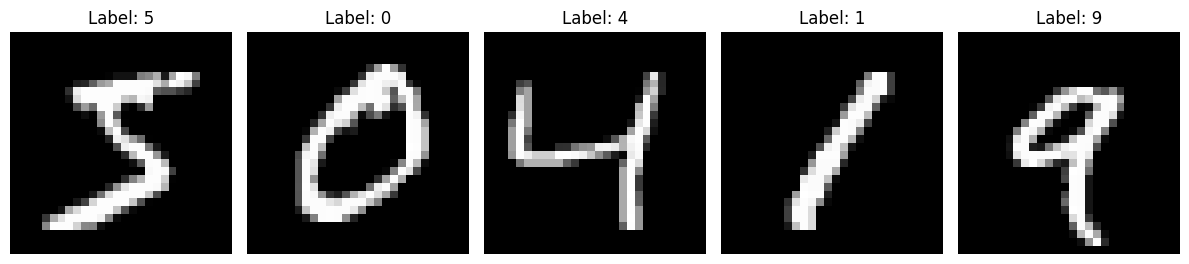


Iterating through one batch from MNIST train_loader:
Batch of images shape: torch.Size([1024, 1, 28, 28])
Batch of labels shape: torch.Size([1024])

========== Finished Processing: MNIST ==========


In [4]:
# Helper function for visualization (handles denormalization and color/grayscale)
def imshow_denormalize(img_tensor, title, mean, std, is_color=True):
    """Shows a denormalized image tensor."""
    # Ensure mean and std are tensors and have the correct shape for broadcasting
    mean = torch.tensor(mean).view(-1, 1, 1) # Shape: [C, 1, 1]
    std = torch.tensor(std).view(-1, 1, 1)   # Shape: [C, 1, 1]

    # Denormalize: image = normalized_image * std + mean
    img = img_tensor * std + mean
    # Clamp values to [0, 1] after denormalization
    img = torch.clamp(img, 0, 1)

    # Prepare for matplotlib
    if is_color:
        # Transpose from (C x H x W) to (H x W x C) for color images
        npimg = img.permute(1, 2, 0).numpy()
        cmap = None
    else:
        # Remove channel dimension for grayscale images
        npimg = img.squeeze().numpy()
        cmap = 'gray'

    plt.imshow(npimg, cmap=cmap)
    plt.title(title)
    plt.axis('off')


def process_dataset(dataset_name, batch_size=1024, num_images_to_show=5, data_root_base='./data'):
    """
    Loads, transforms, creates DataLoaders, and visualizes a specified dataset.

    Args:
        dataset_name (str): Name of the dataset ('MNIST', 'CIFAR-10', 'PCAM').
        batch_size (int): Batch size for DataLoaders.
        num_images_to_show (int): Number of images to display.
        data_root_base (str): Base directory to store dataset folders.

    Returns:
        tuple: (train_loader, test_loader) for the specified dataset, or (None, None) on failure.
    """
    print(f"\n{'='*10} Processing Dataset: {dataset_name} {'='*10}")
    print(f"PyTorch Version: {torch.__version__}")
    print(f"Torchvision Version: {torchvision.__version__}")

    dataset_name_lower = dataset_name.lower()
    mean, std, dataset_class, data_root_suffix, classes, is_color = None, None, None, None, None, None

    # --- Dataset Specific Configurations ---
    if dataset_name_lower == 'mnist':
        mean = (0.5,) # Single channel mean
        std = (0.5,)  # Single channel std
        dataset_class = datasets.MNIST
        data_root_suffix = '_mnist'
        classes = [str(i) for i in range(10)] # Labels 0-9
        is_color = False
    elif dataset_name_lower == 'cifar-10':
        mean = [0.4914, 0.4822, 0.4465] # 3 channels mean
        std = [0.2023, 0.1994, 0.2010]  # 3 channels std
        dataset_class = datasets.CIFAR10
        data_root_suffix = '_cifar10'
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        is_color = True
    elif dataset_name_lower == 'pcam':
        # Check prerequisites for PCAM
        try:
            import h5py
        except ImportError:
            print("Error: h5py package not found. PCAM requires it. Please install: pip install h5py")
            return None, None
        if not hasattr(datasets, 'PCAM'):
            print("Error: torchvision.datasets.PCAM not found.")
            print("Please upgrade torchvision (e.g., 0.16+). Try: pip install --upgrade torchvision")
            return None, None

        # PCAM uses ImageNet means/stds often as default
        mean = [0.485, 0.456, 0.406] # 3 channels mean
        std = [0.229, 0.224, 0.225]  # 3 channels std
        dataset_class = datasets.PCAM
        data_root_suffix = '_pcam'
        classes = {0: 'No Tumor', 1: 'Tumor'} # Dictionary mapping for binary labels
        is_color = True
    else:
        print(f"Error: Dataset '{dataset_name}' not recognized. Choose from 'MNIST', 'CIFAR-10', 'PCAM'.")
        return None, None

    # --- Common Steps ---
    data_root = os.path.join(data_root_base, dataset_name.lower() + data_root_suffix)
    print(f"Data will be stored in: {data_root}")

    # 1. Define Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # 2. Load Dataset
    print(f"Downloading/Loading {dataset_name} dataset...")
    try:
        if dataset_name_lower == 'pcam':
             # PCAM takes 'split' argument instead of 'train'
             # Download might require 'gdown': pip install gdown
             train_dataset = dataset_class(root=data_root, split='train', download=True, transform=transform)
             test_dataset = dataset_class(root=data_root, split='test', download=True, transform=transform)
        else:
             train_dataset = dataset_class(root=data_root, train=True, download=True, transform=transform)
             test_dataset = dataset_class(root=data_root, train=False, download=True, transform=transform)

        print(f"{dataset_name} dataset loaded.")
        print(f"Number of training images: {len(train_dataset)}")
        print(f"Number of test images: {len(test_dataset)}")
    except ImportError as e: # Catch specific import errors if needed (e.g., for gdown)
         print(f"Import Error loading {dataset_name}: {e}. Check prerequisites (h5py, gdown?).")
         return None, None
    except RuntimeError as e:
         print(f"Runtime Error loading {dataset_name}: {e}. Check prerequisites, permissions, or disk space.")
         return None, None
    except Exception as e:
        print(f"An unexpected error occurred loading {dataset_name}: {e}")
        return None, None

    # 3. Create DataLoaders
    # Use num_workers > 0 if your system supports it well, especially for larger datasets like PCAM
    num_workers = 2 if dataset_name_lower == 'pcam' else 0
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    print(f"Created {dataset_name} DataLoaders with batch size {batch_size}.")

    # 4. Visualize Samples
    print(f"\nDisplaying the first {num_images_to_show} {dataset_name} training images...")
    plt.figure(figsize=(12, 3))
    for i in range(num_images_to_show):
        try:
            image, label = train_dataset[i] # Get label (int or tensor)
            # Get class name/string based on dataset's label format
            if isinstance(classes, dict):
                label_str = f"{classes[label]} ({label})" # For PCAM dict {0: 'No Tumor', 1: 'Tumor'}
            elif isinstance(label, torch.Tensor):
                 label_str = classes[label.item()] # Handle tensor labels if any dataset returns them
            else:
                 label_str = classes[label] # For MNIST/CIFAR-10 tuple/list

            plt.subplot(1, num_images_to_show, i + 1)
            # Pass dataset-specific mean, std, and color flag to helper
            imshow_denormalize(image, f'Label: {label_str}', mean, std, is_color=is_color)
        except IndexError:
             print(f"Warning: Could only retrieve {i} images for display.")
             break
        except Exception as e:
             print(f"Error displaying image {i}: {e}")

    plt.tight_layout()
    plt.show()

    # 5. Example: Iterate through one batch
    print(f"\nIterating through one batch from {dataset_name} train_loader:")
    try:
        images, labels = next(iter(train_loader))
        print(f"Batch of images shape: {images.shape}")
        print(f"Batch of labels shape: {labels.shape}")
    except StopIteration:
        print(f"Could not get a batch from {dataset_name} train_loader.")
    except RuntimeError as e:
        # HDF5 + multiprocessing can sometimes cause issues
        print(f"Runtime error iterating {dataset_name} loader: {e}")
        if dataset_name_lower == 'pcam':
            print("Hint: If using num_workers > 0 with PCAM (HDF5), issues can sometimes arise.")
            print("      Try setting num_workers=0 in the DataLoader if problems persist.")

    print(f"\n{'='*10} Finished Processing: {dataset_name} {'='*10}")
    return train_loader, test_loader

# --- Example Usage ---
if __name__ == "__main__":
    # Process MNIST
    train_loader_mnist, test_loader_mnist = process_dataset('MNIST', batch_size=1024)

    # Process CIFAR-10
    #train_loader_cifar10, test_loader_cifar10 = process_dataset('CIFAR-10', batch_size=1024)

    # Process PCAM (PatchCamelyon) - Needs h5py, gdown, and enough disk space
    # Note: First run might take a very long time to download (~8GB)
   # train_loader_pcam, test_loader_pcam = process_dataset('PCAM', batch_size=1024, num_images_to_show=4)

    # You can now use the returned loaders, e.g., for training:
    # if train_loader_mnist:
    #    print("\nMNIST Train loader is ready for use.")

Restnet 34 initilization

In [8]:
# --- Initialization ---
# Use the 'weights' parameter for current PyTorch versions (preferred over 'pretrained=True')
# ResNet34_Weights.IMAGENET1K_V1 specifies weights pre-trained on the ImageNet dataset.
print("Initializing pre-trained ResNet-34 model...")
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
print("Model initialized.")

# --- Optional: Inspect the model structure (first and last layers) ---
print("Original first conv layer:", model.conv1)
print("Original fully connected layer:", model.fc)

Initializing pre-trained ResNet-34 model...
Model initialized.
Original first conv layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Original fully connected layer: Linear(in_features=512, out_features=1000, bias=True)


In [9]:
# --- Adaptation for MNIST (1 input channel, 10 output classes) ---

# Modify the first convolutional layer (model.conv1) to accept 1 input channel
# Original: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
print("Adapting model for MNIST (1 input channel, 10 output classes)...")
original_conv1_weights = model.conv1.weight.data # Keep original weights if needed (e.g., average them)
model.conv1 = nn.Conv2d(
    in_channels=1,        # Change input channels from 3 to 1
    out_channels=64,      # Keep the same number of output filters
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)
# Optional: Initialize new conv1 weights (e.g., average original weights across input channels)
# model.conv1.weight.data = original_conv1_weights.mean(dim=1, keepdim=True)
print("  - Modified model.conv1 to accept 1 input channel.")


# Modify the final fully connected layer (model.fc) for 10 output classes
num_ftrs = model.fc.in_features # Get the number of input features to the original fc layer
model.fc = nn.Linear(num_ftrs, 10) # Replace with a new linear layer for 10 classes
print(f"  - Replaced model.fc for {10} output classes.")
print("Model adapted.")

# --- Optional: Verify the modified layers ---
print("Modified first conv layer:", model.conv1)
print("Modified fully connected layer:", model.fc)

Adapting model for MNIST (1 input channel, 10 output classes)...
  - Modified model.conv1 to accept 1 input channel.
  - Replaced model.fc for 10 output classes.
Model adapted.
Modified first conv layer: Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Modified fully connected layer: Linear(in_features=512, out_features=10, bias=True)


In [2]:
# --- Moving Model to GPU (if available) ---

# Check if CUDA (GPU support) is available and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the selected device (GPU or CPU)
model.to(device)
print(f"Model moved to {device}.")

# Now you can proceed with training or inference using data tensors also sent to this device.
# Example: images = images.to(device)
#          labels = labels.to(device)
#          outputs = model(images)

Using device: cuda:0


NameError: name 'model' is not defined

In [56]:
device = torch.device("cpu")
model.to(device)
print(f"Model moved to {device}.")

Model moved to cpu.


Model Training

In [11]:
import torch
import gc

# Loop through all available GPUs
for gpu_id in range(torch.cuda.device_count()):
    torch.cuda.set_device(gpu_id)  # Set the current GPU
    torch.cuda.empty_cache()       # Clear the cache for this GPU
    gc.collect()                   # Trigger garbage collection

print("All GPU memory has been cleared.")


All GPU memory has been cleared.


In [10]:
# Specify primary GPU (e.g., 0), and let PyTorch handle the rest
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)
# print(f"Model moved to {device}.")

# Wrap model for multi-GPU training
model = nn.DataParallel(model,device_ids=[0,1])  # This will use all available GPUs

# model.to(device)
print(f"Using device: {device}")


Using device: cuda:0


In [ ]:
import torch.nn.functional as F
from torch import optim

# --- Hyperparameters ---
num_epochs = 5  # You can change this
learning_rate = 0.0001

# --- Loss Function & Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Training Loop ---
print(f"\nStarting training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = total_correct / total_samples * 100
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Training completed.")
torch.cuda.empty_cache()
gc.collect()  # Clear GPU memory after training
# --- Save the Model ---            
model_path = 'mnist_resnet34.pth'
torch.save(model.state_dict(), model_path)      
print(f"Model saved to {model_path}.")


Starting training for 5 epochs...
Epoch [1/5] - Loss: 0.2084, Accuracy: 94.86%
Epoch [2/5] - Loss: 0.0154, Accuracy: 99.59%
Epoch [3/5] - Loss: 0.0078, Accuracy: 99.83%
Epoch [4/5] - Loss: 0.0033, Accuracy: 99.95%
Epoch [5/5] - Loss: 0.0020, Accuracy: 99.97%
Training completed.


Model Testing


✅ Test Accuracy: 99.63%


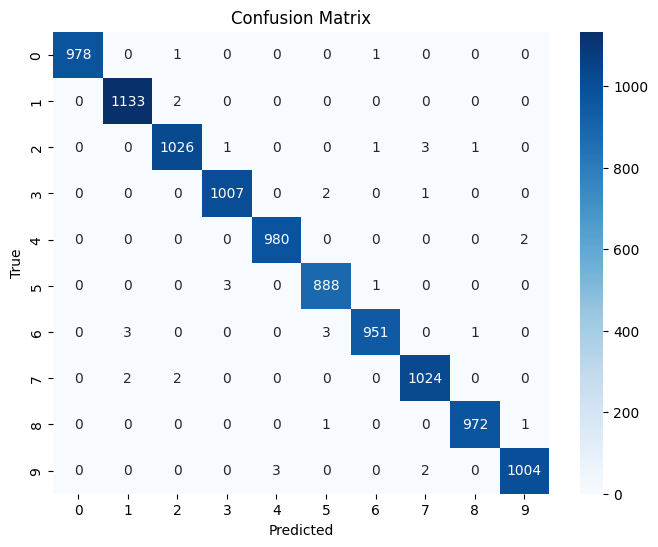


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       1.00      1.00      1.00       982
           5       0.99      1.00      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      1.00      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- Evaluation on Test Set ---
model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient tracking
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Accuracy ---
correct = sum(p == t for p, t in zip(all_preds, all_labels))
accuracy = correct / len(all_labels) * 100
print(f"\n✅ Test Accuracy: {accuracy:.2f}%")

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Classification Report ---
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds))
torch.cuda.empty_cache()


GRADCAM

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Import the Grad-CAM library ---
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
except ImportError:
    print("Please install the pytorch-grad-cam library: pip install grad-cam")
    exit()

# Assume 'model' is your trained PyTorch model (e.g., adapted ResNet-34)
# Assume 'test_loader' is your DataLoader for the test set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Ensure Model is Ready ---
model.eval()
model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

# --- 2. Identify Target Layer(s) ---
# For MNIST models, try different convolutional layers
try:
    # Option 1: If using ResNet architecture
    target_layers = [model.layer4[-1]]  # Try earlier layers if this doesn't work
    print(f"Using ResNet-style target layer: {type(target_layers[0])}")
except AttributeError:
    try:
        # Option 2: For simpler CNN architectures, try to find the last conv layer
        # This assumes a typical structure where conv layers are followed by a classifier
        conv_layers = [module for name, module in model.named_modules() 
                     if isinstance(module, torch.nn.Conv2d)]
        target_layers = [conv_layers[-1]]  # Use the last conv layer
        print(f"Using last conv layer as target: {type(target_layers[0])}")
    except (AttributeError, IndexError):
        print("Could not find suitable conv layers. Please inspect your model structure:")
        print(model)
        print("Set target_layers manually to a suitable Conv layer.")
        exit()

# --- 3. Initialize GradCAM (instead of GradCAM++) ---
try:
    cam = GradCAM(model=model, target_layers=target_layers)
    print("GradCAM initialized successfully.")
except Exception as e:
    print(f"Error initializing GradCAM: {e}")
    exit()

# --- 4. Prepare Input Image and Target ---
print("Preparing sample image for explanation...")
try:
    # Get a sample batch with gradients enabled
    images, labels = next(iter(test_loader))
    input_tensor = images[0:1].to(device)  # Take the first image, keep batch dim
    
    # Forward pass to check prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
    
    label = labels[0].item()  # Ground truth label
    pred = predicted[0].item()  # Predicted label
    print(f"Ground truth: {label}, Model prediction: {pred}")
    
except StopIteration:
    print("Could not get data from test_loader. Is it empty?")
    exit()
except Exception as e:
    print(f"Error preparing sample: {e}")
    exit()

# Define the target for explanation - can use ground truth or prediction
# targets = [ClassifierOutputTarget(label)]  # To explain why it's the ground truth class
# targets = [ClassifierOutputTarget(pred)]   # To explain why it's the predicted class
targets = None  # To use the highest scoring class (default)

print(f"Explaining {'prediction' if targets is None else 'class ' + str(targets[0].category)}")

# --- 5. Generate the CAM ---
print("Generating GradCAM...")
try:
    cam_result = cam(input_tensor=input_tensor, targets=targets)
    # Take the CAM for the first image in the batch
    grayscale_cam = cam_result[0, :]
    
    # Check CAM values
    print(f"CAM values - min: {grayscale_cam.min():.5f}, max: {grayscale_cam.max():.5f}")
    
    # Normalize CAM if values are very small or uniform
    if grayscale_cam.max() - grayscale_cam.min() < 0.01:
        print("Warning: CAM values have low range, normalizing...")
        # Try stronger normalization to enhance any subtle differences
        grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)
        # Check if still too uniform
        if np.std(grayscale_cam) < 0.01:
            print("Warning: CAM still too uniform after normalization")
        print(f"After normalization - min: {grayscale_cam.min():.5f}, max: {grayscale_cam.max():.5f}")
        
except Exception as e:
    print(f"Error generating CAM: {e}")
    print(f"Input tensor device: {input_tensor.device}, Model device: {next(model.parameters()).device}")
    exit()

print("GradCAM generated.")

# --- 6. Prepare Original Image for Visualization ---
print("Preparing visualization...")
# Get original image in a viewable format
img_for_viz = input_tensor[0].cpu()

# Denormalize (update these with your actual mean/std values)
mean = torch.tensor([0.5])  # Common for MNIST
std = torch.tensor([0.5])   # Common for MNIST

# Adjust shape for broadcasting based on number of channels
if img_for_viz.shape[0] == 3:  # Color
    mean = mean.view(3, 1, 1)
    std = std.view(3, 1, 1)
elif img_for_viz.shape[0] == 1:  # Grayscale
    mean = mean.view(1, 1, 1)
    std = std.view(1, 1, 1)

img_denorm = img_for_viz * std + mean
img_denorm = torch.clamp(img_denorm, 0, 1)  # Clamp to [0, 1]

# Convert to NumPy HWC format
img_np_hwc = img_denorm.permute(1, 2, 0).numpy()

# Handle grayscale images for visualization
if img_np_hwc.shape[2] == 1:
    # Create RGB version for heatmap overlay
    img_np_rgb = np.repeat(img_np_hwc, 3, axis=2)
else:
    img_np_rgb = img_np_hwc

# --- 7. Create Visualizations ---
plt.figure(figsize=(15, 5))

# 1. Original image
plt.subplot(1, 3, 1)
if img_for_viz.shape[0] == 1:  # If original is grayscale
    plt.imshow(img_np_hwc[:,:,0], cmap='gray')
else:
    plt.imshow(img_np_hwc)
plt.title(f"Original Image (Label: {label})")
plt.axis('off')

# 2. CAM heatmap only
plt.subplot(1, 3, 2)
plt.imshow(grayscale_cam, cmap='jet')
plt.colorbar(label='Class Activation')
plt.title("GradCAM Heatmap")
plt.axis('off')

# 3. Combined visualization with explicit JET colormap
# Using a higher opacity for better visibility
visualization = show_cam_on_image(img_np_rgb, grayscale_cam, use_rgb=True, 
                                 colormap=cv2.COLORMAP_JET, image_weight=0.7)

plt.subplot(1, 3, 3)
plt.imshow(visualization)
plt.title(f"GradCAM Overlay (Pred: {pred})")
plt.axis('off')

plt.tight_layout()
plt.savefig('./data/images/gradcam_visualization.png', bbox_inches='tight', dpi=150)
plt.show()
print("Visualization complete.")

# --- 8. Try Alternate Visualization (Optional) ---
# If the above doesn't work well, try a different approach
plt.figure(figsize=(10, 10))
# Create custom overlay for better visibility
alpha = 0.7  # Heatmap opacity
heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
img_uint8 = np.uint8(255 * img_np_rgb)
superimposed = cv2.addWeighted(img_uint8, 1-alpha, heatmap, alpha, 0)

plt.imshow(superimposed)
plt.title(f"Enhanced GradCAM Visualization\nTrue: {label}, Predicted: {pred}")
plt.axis('off')
plt.savefig('./data/images/gradcam_enhanced.png', bbox_inches='tight', dpi=150)
plt.show()

NameError: name 'model' is not defined

GRADCAM++

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Import the Grad-CAM++ library ---
try:
    from pytorch_grad_cam import GradCAMPlusPlus  # Changed to GradCAMPlusPlus
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
except ImportError:
    print("Please install the pytorch-grad-cam library: pip install grad-cam")
    exit()

# Assume 'model' is your trained PyTorch model (e.g., adapted ResNet-34)
# Assume 'test_loader' is your DataLoader for the test set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Ensure Model is Ready ---
model.eval()
model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

# --- 2. Identify Target Layer(s) ---
# For MNIST models, try different convolutional layers
try:
    # Option 1: If using ResNet architecture
    target_layers = [model.layer4[-1]]  # Try earlier layers if this doesn't work
    print(f"Using ResNet-style target layer: {type(target_layers[0])}")
except AttributeError:
    try:
        # Option 2: For simpler CNN architectures, try to find the last conv layer
        conv_layers = [module for name, module in model.named_modules() 
                     if isinstance(module, torch.nn.Conv2d)]
        target_layers = [conv_layers[-1]]  # Use the last conv layer
        print(f"Using last conv layer as target: {type(target_layers[0])}")
    except (AttributeError, IndexError):
        print("Could not find suitable conv layers. Please inspect your model structure:")
        print(model)
        print("Set target_layers manually to a suitable Conv layer.")
        exit()

# --- 3. Initialize GradCAM++ ---  # Changed section
try:
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)  # Changed to GradCAMPlusPlus
    print("Grad-CAM++ initialized successfully.")
except Exception as e:
    print(f"Error initializing Grad-CAM++: {e}")
    exit()
# --- 4. Prepare Input Images and Targets ---
print("Preparing sample images for explanation...")
try:
    # Get a batch of images and labels
    images, labels = next(iter(test_loader))
    input_tensors = images[:5].to(device)  # Take the first 5 images (or adjust the number as needed)
    
    # Forward pass to check predictions
    with torch.no_grad():
        outputs = model(input_tensors)
        _, predictions = torch.max(outputs, 1)
    
    labels = labels[:5]  # Ground truth labels for the selected images
    predictions = predictions[:5]  # Predicted labels for the selected images
    print(f"Ground truth labels: {labels.tolist()}")
    print(f"Model predictions: {predictions.tolist()}")
    
except StopIteration:
    print("Could not get data from test_loader. Is it empty?")
    exit()
except Exception as e:
    print(f"Error preparing samples: {e}")
    exit()

# --- 5. Generate the CAM for Multiple Images ---
print("Generating GradCAM for multiple images...")
try:
    cam_results = cam(input_tensor=input_tensors, targets=None)  # Generate CAMs for all selected images
    grayscale_cams = cam_results  # CAMs for all images in the batch
    
    # Check CAM values for the first image
    print(f"First CAM values - min: {grayscale_cams[0].min():.5f}, max: {grayscale_cams[0].max():.5f}")
    
except Exception as e:
    print(f"Error generating CAMs: {e}")
    exit()

# --- 6. Visualize Multiple Images ---
print("Preparing visualizations for multiple images...")
plt.figure(figsize=(15, 10))

for i in range(len(input_tensors)):
    # Prepare the original image for visualization
    img_for_viz = input_tensors[i].cpu()
    mean = torch.tensor([0.5])  # Adjust mean and std for your dataset
    std = torch.tensor([0.5])
    
    if img_for_viz.shape[0] == 3:  # Color
        mean = mean.view(3, 1, 1)
        std = std.view(3, 1, 1)
    elif img_for_viz.shape[0] == 1:  # Grayscale
        mean = mean.view(1, 1, 1)
        std = std.view(1, 1, 1)
    
    img_denorm = img_for_viz * std + mean
    img_denorm = torch.clamp(img_denorm, 0, 1)
    img_np_hwc = img_denorm.permute(1, 2, 0).numpy()
    
    # Handle grayscale images for visualization
    if img_np_hwc.shape[2] == 1:
        img_np_rgb = np.repeat(img_np_hwc, 3, axis=2)
    else:
        img_np_rgb = img_np_hwc
    
    # Get the corresponding CAM
    grayscale_cam = grayscale_cams[i]
    
    # Create the visualization
    visualization = show_cam_on_image(img_np_rgb, grayscale_cam, use_rgb=True, colormap=cv2.COLORMAP_JET, image_weight=0.7)
    
    # Plot the original image, CAM heatmap, and overlay
    plt.subplot(len(input_tensors), 3, i * 3 + 1)
    if img_for_viz.shape[0] == 1:
        plt.imshow(img_np_hwc[:, :, 0], cmap='gray')
    else:
        plt.imshow(img_np_hwc)
    plt.title(f"Original Image (Label: {labels[i].item()})")
    plt.axis('off')
    
    plt.subplot(len(input_tensors), 3, i * 3 + 2)
    plt.imshow(grayscale_cam, cmap='jet')
    plt.colorbar(label='Class Activation')
    plt.title("GradCAM Heatmap")
    plt.axis('off')
    
    plt.subplot(len(input_tensors), 3, i * 3 + 3)
    plt.imshow(visualization)
    plt.title(f"GradCAM Overlay (Pred: {predictions[i].item()})")
    plt.axis('off')

plt.tight_layout()
plt.savefig('./data/images/gradcam_multiple_visualizations.png', bbox_inches='tight', dpi=150)
plt.show()
print("Visualizations complete.")

Model is on device: cuda:0
Using ResNet-style target layer: <class 'torchvision.models.resnet.BasicBlock'>
Grad-CAM++ initialized successfully.
Preparing sample images for explanation...
Ground truth labels: [0, 24, 37, 45, 97]
Model predictions: [567, 126, 409, 512, 278]
Generating GradCAM for multiple images...
Error generating CAMs: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.
Preparing visualizations for multiple images...


RuntimeError: shape '[3, 1, 1]' is invalid for input of size 1

<Figure size 1500x1000 with 0 Axes>

: 

SHAP

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import shap

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Model Preparation ---
model = models.resnet18(pretrained=True).to(device)
model.eval()  # Keep model in eval mode but enable gradients for explanation

# --- 2. Data Preparation with Gradients ---
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load sample data with gradient tracking
test_loader = DataLoader(
    torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform),
    batch_size=32,
    shuffle=True
)

# --- 3. Prepare Inputs with Gradient Tracking ---
def prepare_data(loader, device):
    images, labels = next(iter(loader))
    return images[0:1].clone().to(device).requires_grad_(True), labels[0].item()

# Get sample to explain
sample_image, true_label = prepare_data(test_loader, device)

# Prepare background data (50 samples)
background_data = []
for batch_idx, (data, _) in enumerate(test_loader):
    if batch_idx >= 2:  # 2 batches * 32 = 64 samples
        break
    background_data.append(data.to(device).requires_grad_(True))
background = torch.cat(background_data)[:50]

# --- 4. SHAP Explanation with Gradient Context ---
explainer = shap.DeepExplainer(model, background)

with torch.enable_grad():  # Critical: enable gradient context
    shap_values = explainer.shap_values(sample_image, check_additivity=False)

# --- 5. Visualization ---
# Process outputs
shap_np = shap_values[0].squeeze().transpose(1, 2, 0)
sample_np = sample_image.detach().cpu().squeeze().numpy().transpose(1, 2, 0)

# Denormalize
sample_np = sample_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
sample_np = np.clip(sample_np, 0, 1)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(sample_np)
plt.title(f"Original Image\nTrue Label: {true_label}")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(shap_np.mean(axis=-1), cmap='jet')
plt.colorbar(label='Feature Importance')
plt.title("SHAP Importance Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sample_np)
plt.imshow(shap_np.mean(axis=-1), cmap='jet', alpha=0.4)
plt.title("Combined Visualization")
plt.axis('off')

plt.tight_layout()
plt.savefig('shap_explanation.png', bbox_inches='tight', dpi=150)
plt.show()

/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 345MB/s]
100%|██████████| 169M/169M [00:05<00:00, 29.5MB/s] 


RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.